In [1]:
# imports
import pandas as pd
import numpy as np
from IPython.core.debugger import set_trace
import torch
import matplotlib.pyplot as plt
import subprocess

# Export notebook as python script to the ../python-code - folder

In [7]:
subprocess.run("jupyter nbconvert --output-dir='../python-code' --to python TLMF.ipynb --TemplateExporter.exclude_markdown=True --TemplateExporter.exclude_input_prompt=True", shell=True)

CompletedProcess(args="jupyter nbconvert --output-dir='../python-code' --to python TLMF.ipynb --TemplateExporter.exclude_markdown=True --TemplateExporter.exclude_input_prompt=True", returncode=0)

# TLMF - Algorithm

In [12]:
class TLMF():
    """
    A class that represents the Two-Level-Matrix-Factorization (TLMF).
    """
    
    def __init__(self, wtmf, rmh, mode:str="Conviction"):
        """
        Params:
            wtmf (WTMF): A wtmf (Weighted Text Matrix Factorization) - object. This object represents the first level of the TLMF. It contains the argument similarity matrix which is used in TLMF.
            rmh (Rating_Matrix_Handler): A Rating_Matrix_Handler object that contains the final rating matrix that consists of the training data - entires as well as the masked test data - entries and which
            is used for optimizing the TLMF on. It also contains the indices of the original test-set in order to perform evaluation.
            mode (str, optional): The task on which the tlmf-model is trained. Depending on the task it is trained on other subsets of data. Can take values ['Conviction','Weight']
            Defaults to 'Conviction'.
        """
        self.wtmf = wtmf
        self.rmh = rmh
        # Initialize GPU for computation if available            
        machine = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(machine)
        # Assertions
        assert(mode == "Conviction" or mode == "Weight"), f"Unkown task - description {mode} was passed."
        self.mode_ = mode

    def train(self, d:int=20, training_iterations:int=50, random_seed:int=1, print_frequency:int=1, r:float=0.05, lambda_:float=0.01, alpha:float=0.2, n:int=10) -> [float]:
        """
        Use stochastic gradient descent to find the two optimal latent factor matrices U (Users), I (Items) 
        that minimizes the difference between the predicted values of the dot product of user-vectors and item-vectors compared to the known ratings in the user-item matrix.
        
        Params:
            d (int, optional): The embedding dimension of the user and item vectors within the latent factor matrices. Defaults to 20.
            training_iterations (int, optional): The number of training iterations over known user-item ratings. Defaults to 50.
            random_seed (int, optional):  Random seed that is used to intialize the latent factor matrices. Defaults to 1.. Defaults to 1.
            print_frequency (int, optional): The frequency in which the training error is printed w.r.t. to the iterations. Defaults to 1.
            r (float, optional): The regularization factor that controls the overfitting of the model. Defaults to 0.05.
            lambda_ (float, optional): The learning rate, a parameter that determines how heavily the vectors of the latent factor matrices are updated in every iteration. Defaults to 0.01.
            alpha (float, optional): The parameter that controls the influence of the semantic relations of the items in the prediction. Defaults to 0.02.
            n (int, optional): The n most similar items to item i that are considered for any prediction in which item i is involved.
            
        Returns:
            [float]: A list containing the error values for every iteration.
        """
        if self.mode_=="Conviction":
            # Select all conviction columns with values in the range [0,1]
            # Get all relevant column-indices
            idxs = torch.arange(1, self.rmh.final_rating_matrix.shape[1], 2)
            trimmed_rating_matrix = torch.index_select(self.rmh.final_rating_matrix, 1, idxs)
        elif self.mode_=="Weight":
            # Select all weight columns with values in the range [0,6]
            # Get all relevant column-indices
            idxs = torch.arange(0, self.rmh.final_rating_matrix.shape[1], 2)           
            trimmed_rating_matrix = torch.index_select(self.rmh.final_rating_matrix, 1, idxs)
        
        # Set random seed for reproducability
        torch.manual_seed(random_seed)
        
        # Randomly initialize the latent factor matrices U(ser) and I(tems)
        self.U = torch.rand([trimmed_rating_matrix.shape[0], d]).to(self.device)
        self.I = torch.rand([trimmed_rating_matrix.shape[1], d]).to(self.device)
        
        # Error - variable: keep track of each error in every iteration for later visualization 
        error = []
        error_cur = 0.0
        frobenius_norm = torch.linalg.matrix_norm

        # Get non-na indices of rating - matrix to train TLMF on
        training_indices = (~torch.isnan(trimmed_rating_matrix)).nonzero().to(torch.int).to(self.device)
        sample_counter = 0
        for iteration in range(training_iterations):
            for idx in training_indices:
                sample_counter +=1
                # Get the index of the current user within the training matrix
                user = idx[0]
                # Get the index of the current argument within the training matrix
                arg = idx[1]
                # Get the column- indices of the n items that are most similar to the current item in the argument similarity matrix
                most_sim_indices = torch.topk(self.wtmf.similarity_matrix[arg], n, dim=0, sorted=False)[1]
                
                ######## 
                # Calculate the sum of similarities over the n most similar args
                ########
                sim_sum_scaled = torch.zeros(self.I[arg].shape)
                    
                for arg_neighbor_index, sim_value in enumerate(most_sim_indices):
                    sim_sum_scaled = torch.add(sim_sum_scaled, torch.mul(self.I[arg_neighbor_index], self.wtmf.similarity_matrix[arg][arg_neighbor_index]))
                    
                sim_sum_scaled = torch.sub(self.I[arg], sim_sum_scaled)
                sim_sum_scaled = torch.matmul(sim_sum_scaled, sim_sum_scaled.T)
                sim_sum_scaled = torch.mul(sim_sum_scaled, alpha)
                    
                prediction = self.U[user].matmul(self.I.T[:,arg])
                true_value = trimmed_rating_matrix[user][arg]
                
                difference = true_value - prediction
                error_cur += torch.pow(difference,2) + (r/2 * (frobenius_norm(self.U) + frobenius_norm(self.I))) + sim_sum_scaled

                # Save old value of the user - vector for updating the item - vector (TODO: Not sure if I should already use the updated user-vector for updating the item vector)
                old_user_vector = self.U[user]

                # Update the user-vector
                self.U[user] = torch.add(self.U[user], torch.mul((torch.sub(torch.mul(self.I[arg], difference), torch.mul(self.U[user], r))), lambda_))
                                        
                ########
                # Calculate the similarity sum components to update the item latent vector (equation 16)
                ########
                # First component
                sim_sum = torch.zeros(self.I[arg].shape)
                for arg_neighbor_idx in most_sim_indices:
                   sim_sum = torch.add(sim_sum, torch.mul(self.I[arg_neighbor_idx], self.wtmf.similarity_matrix[arg][arg_neighbor_idx])) 
                sim_sum = torch.sub(self.I[arg], sim_sum)
                sim_sum = torch.mul(sim_sum, alpha)
                
                # Second component
                sim_sum2 = torch.zeros(self.I[arg].shape)
                # Calculate the most similar arg-indices to the neighbor args
                # Create a list to hold a tuple of (neighour_arg_idx, list_of_similar_args_to_neighbor) of the args for every neighbor arg
                most_sim_args_of_neighbors = [] 
                for idx, sim_arg in enumerate(most_sim_indices):
                    most_sim_args_of_neighbors.append(torch.topk(self.wtmf.similarity_matrix[sim_arg], n, dim=0, sorted=False)[1])
                    
                for neighbor in most_sim_indices:
                    for idxs in most_sim_args_of_neighbors:
                        for neighbor_of_neighbor in idxs:
                            #set_trace()
                            sim_sum2 = torch.add(sim_sum2, torch.mul(self.I[neighbor_of_neighbor], self.wtmf.similarity_matrix[neighbor][neighbor_of_neighbor]))
                        sim_sum2 = torch.sub(self.I[neighbor], sim_sum2)
                        sim_sum2 = torch.mul(sim_sum2, self.wtmf.similarity_matrix[neighbor][arg])
                    
                sim_sum2 = torch.mul(sim_sum2, alpha)
                sim_sum = torch.add(sim_sum, sim_sum2)
                self.I[arg] = torch.add(self.I[arg], (torch.mul( torch.sub(torch.sub(torch.mul( self.U[user], difference), torch.mul(self.I[arg], r)), sim_sum), lambda_)))
            try:
                if error_cur > error[-1]:
                    break
            except:
                pass
                            
            error.append(error_cur)
            error_cur = 0.0
                 
            # Print out error w.r.t print-frequency
            if (iteration + 1) % print_frequency == 0:
                print(f"Training - Error:{error[iteration]:.2f}\tCurrent Iteration: {iteration+1}\\{training_iterations}")
       
        return error

    def calculate_mode_values(self, n:int=2) -> tuple:
      """
      Calculates two dictionaries.
      The first dictionary contains an argument index as key and the indices
      of the n most similar arguments as a torch.tensor as value.
      The second dictionary contains an argument index as key and the modal
      value of this argument as a value.  
      
      Params:
        n (int, optional): The number of similar arguments to consider.

      Returns:
        A tuple of two dictionaries, where the first dictionary is at index 0
        and the second dictionary is at index 1.
      """
      # First dictionary
      sim_args_dict = {arg_idx: torch.topk(self.wtmf.similarity_matrix[arg_idx], n, dim=0, sorted=False)[1] for arg_idx in self.wtmf.similarity_matrix.shape[1]}
      # Second dictionary
      args_mode_dict = {arg_idx: torch.mode(self.trimmed_rating_matrix[:,arg_idx])[0] for arg_idx in sim_args_dict.keys()}

      return (sim_args_dict, args_mode_dict)
    
    def evaluate(self) -> float:
        """
        Returns:
            float: A float that represents the error of the TLMF-model on the test set. 
        """
        
        # Filter the evaluation indices based on the task
        if self.mode_ == "Conviction":
            #Get odd-indexed arguments that correspond to conviction arguments in the range [0,1]        
            self.rmh.test_eval_indices = {user:items[items % 2 == 1] for user,items in self.rmh.test_eval_indices.items()}
            # To match the indices of the training, integer divide all odd indices by 2 to map them to the correct index
            for key, value in self.rmh.test_eval_indices.items():
                self.rmh.test_eval_indices[key] = value // 2 
            # Get rid of the username column in the test-rating -matrix for converting only numerical values into a pytorch tensor
            test_rating_matrix_copy = self.rmh.test_rating_matrix.drop(["username"], axis=1)
            # Trim the original test_rating_matrix to the conviction columns only
            trimmed_test_rating_matrix = torch.index_select(torch.from_numpy(test_rating_matrix_copy.values).to(torch.float16), 1, torch.arange(1, test_rating_matrix_copy.shape[1], 2))
            # Calculate the mean-accuracy for the Prediction of Conviction (PoC) - task 
            mean_acc = 0.0
            # Variable for counting the correct 0/1 prediction
            count_equality = 0
            for username, test_samples in self.rmh.test_eval_indices.items():
                # The actual username of the user
                username_str = username[0]
                # The row-index in the test set of that user
                user_idx_test = username[1]
                # Get the row-index for the user in the latent user-vector
                user_idx_pred = self.rmh.final_rating_matrix_w_usernames[self.rmh.final_rating_matrix_w_usernames["username"]==username_str].index[0]
                for arg_idx in test_samples:
                    # If the prediction is correct, increment the counter
                    true_value = trimmed_test_rating_matrix[user_idx_test][arg_idx]
                    prediction = torch.round(self.U[user_idx_pred].matmul(self.I[arg_idx].T))
                    if  true_value == prediction:
                        count_equality += 1
                # Normalize by the number of test samples for this user
                mean_acc += count_equality / len(test_samples)
                # Set the count equality to 0 for the next user
                count_equality = 0
            # Normalize the error by the number of users in the test-set
            mean_acc /= len(self.rmh.test_eval_indices)
        
            return mean_acc
        
        elif self.mode_=="Weight":
            self.rmh.test_eval_indices = {user:items[items % 2 == 0] for user,items in self.rmh.test_eval_indices.items()}
            # To match the indices of the training, integer divide all odd indices by 2 to map them to the correct index
            for key, value in self.rmh.test_eval_indices.items():
                self.rmh.test_eval_indices[key] = value // 2
            # Get rid of the username column in the test-rating -matrix for proper indexing
            test_rating_matrix_copy = self.rmh.test_rating_matrix.drop(["username"], axis=1) 
            # Trim the original test_rating_matrix to the weight columns only
            trimmed_test_rating_matrix = torch.index_select(torch.from_numpy(test_rating_matrix_copy.values).to(torch.float16), 1, torch.arange(0, test_rating_matrix_copy.shape[1], 2))
            # Calculate the averaged root mean squared error for the Prediction of Weight (PoW) - task
            rmse_error = 0.0
            # Variable for measuring the distance of the true value and the prediction
            prediction_distance = 0.0
            for username, test_samples  in self.rmh.test_eval_indices.items():
                user_idx = username[1]
                for arg_idx in test_samples:
                    # If the prediction is correct, increment the counter
                    prediction_distance += (trimmed_test_rating_matrix[user_idx][arg_idx] - torch.round(self.U[user_idx].matmul(self.I[arg_idx].T)))**2 
                    # Normalize by the number of test samples for this user
                rmse_error += prediction_distance / len(test_samples)
                # Set the prediction distance to 0 for the next user
                prediction_distance = 0
            # Normalize the prediction_distance by the number of users in the test-set
            rmse_error /= len(self.rmh.test_eval_indices)
            
            return rmse_error
        
    def plot_training_error(self, error:[float], **kwargs) -> None:
        """
        Plots the training error for every training iteration.
        
        Params:
            error (list): A list of error - values that correspond to each training iteration of the TLMF - algorithm.    
            **kwargs: Arbitrary many keyword arguments to customize the plot. E.g. color, linewidth or title.
        """ 
        plt.plot([i for i in range(1, len(error)+1)], error)
        for k in kwargs.keys():
            # Invoke the function k of the plt - module to customize the plot
            getattr(plt, k) (kwargs[k])
        
        plt.show()

Error:436.81	Current Iteration: 1\20
Error:296.09	Current Iteration: 2\20
Error:279.33	Current Iteration: 3\20
Error:270.02	Current Iteration: 4\20
Error:263.53	Current Iteration: 5\20
Error:258.55	Current Iteration: 6\20
Error:254.50	Current Iteration: 7\20
Error:251.07	Current Iteration: 8\20
Error:248.07	Current Iteration: 9\20
Error:245.40	Current Iteration: 10\20
Error:242.99	Current Iteration: 11\20
Error:240.77	Current Iteration: 12\20
Error:238.72	Current Iteration: 13\20
Error:236.81	Current Iteration: 14\20
Error:235.02	Current Iteration: 15\20
Error:233.33	Current Iteration: 16\20
Error:231.73	Current Iteration: 17\20
Error:230.21	Current Iteration: 18\20
Error:228.76	Current Iteration: 19\20
Error:227.37	Current Iteration: 20\20


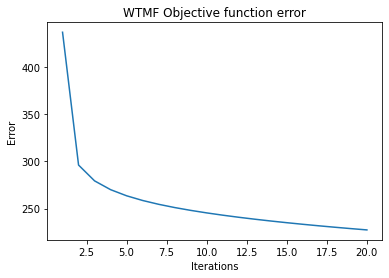

In [3]:
k=20
training_iterations=20
weight=0.05
gamma=0.001
random_seed=8
print_frequency=1
%run WTMF.ipynb

In [9]:
# Parameters for executing the Rating-Matrix-Handler notebook
train_path = f"C:/Users/Rico/Desktop/bachelor-thesis/data/T1_T2/train.csv"
test_path  = f"C:/Users/Rico/Desktop/bachelor-thesis/data/T1_T2/test.csv"
%run Rating_Matrix_Handler.ipynb

In [10]:
def random_search(tlmf:TLMF, num_experiments:int=10, **param_values) -> dict:
    """
    Perform a random search for the best parameter-values for the tlmf algorithm.
    
    Params:
        tlmf (TLMF): A TLMF-object containing that is used to predict the unknown ratings.
        num_experiments: The number of optimization experiments with random parameter values that should be carried out.
        **param_values (kwargs): A dictionary of keys(parameter_name) and values (list of values to try out for that parameter).
        
    Returns: A list of tuples containing the prediction - score on index 0 and the parameter-values on index 1. 
    """
    # List containing tuples of (score, parameter-values) 
    results = []
    for i in range(num_experiments):
        print(f"Experiment {i+1}:\n")
        # Parameters for executing the Rating-Matrix-Handler notebook
        train_path = f"C:/Users/Rico/Desktop/bachelor-thesis/data/T1_T2/train.csv"
        test_path  = f"C:/Users/Rico/Desktop/bachelor-thesis/data/T1_T2/test.csv"
        %run Rating_Matrix_Handler.ipynb
        tlmf = TLMF(tlmf.wtmf, rmh)
        # Set parameters to random values
        execution_dict = {param:np.random.choice(values) for param, values in param_values.items()}
        # Run training    
        train_error = tlmf.train(**execution_dict)
        test_result = tlmf.evaluate()
        results.append((test_result, execution_dict))
    return results

In [13]:
tlmf = TLMF(wtmf, rmh)
params = {"d":np.array([12, 13, 14, 15, 16, 17]),
          "alpha":np.array([0.00001, 0.001]),
          "n":np.array([1,2,3]),
          "training_iterations":np.array([10, 20, 50, 100]), 
          "random_seed":np.array([8, 9, 11]), 
          "print_frequency":np.array([10]), 
          "r":np.array([0.01, 0.001, 0.005, 0.008, 0.0001, 0.00001]), 
          "lambda_":np.array([0.1, 0.01, 0.02, 0.001, 0.005, 0.008, 0.0001, 0.00001])
          }
results = random_search(tlmf, num_experiments=1, **params)

Experiment 1:



KeyboardInterrupt: 